<a href="https://colab.research.google.com/github/Abhi-213/Breast-Cancer-Detection/blob/main/Breast_Cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle


In [3]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d forderation/breakhis-400x

Dataset URL: https://www.kaggle.com/datasets/forderation/breakhis-400x
License(s): CC0-1.0
 99% 791M/803M [00:09<00:00, 102MB/s] 
100% 803M/803M [00:09<00:00, 92.0MB/s]


In [7]:
!unzip /content/breakhis-400x.zip

Archive:  /content/breakhis-400x.zip
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png  
  inflating: BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-006.png  
  inflating: BreaKHis 400X/

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


In [9]:
class BreaKHisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label in ['benign', 'malignant']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.images.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'benign' else 1)  # 0: benign, 1: malignant

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [11]:

train_dataset = BreaKHisDataset(root_dir='/content/BreaKHis 400X/train', transform=transform)
test_dataset = BreaKHisDataset(root_dir='/content/BreaKHis 400X/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust the input size based on the output of the last pooling layer
        self.fc2 = nn.Linear(128, 2)  # Two classes: benign and malignant

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.5164
Epoch [2/10], Loss: 0.9544
Epoch [3/10], Loss: 0.3483
Epoch [4/10], Loss: 0.2043
Epoch [5/10], Loss: 0.2615
Epoch [6/10], Loss: 0.1910
Epoch [7/10], Loss: 0.0310
Epoch [8/10], Loss: 0.0052
Epoch [9/10], Loss: 0.0195
Epoch [10/10], Loss: 0.0029


In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 83.12%


In [15]:
import matplotlib.pyplot as plt

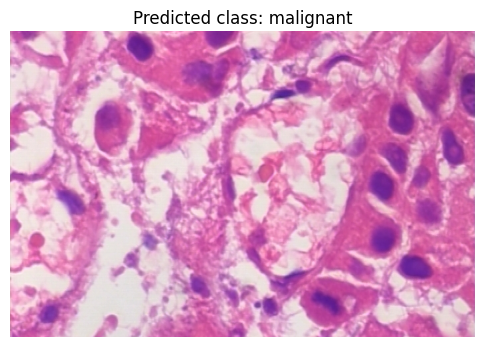

In [17]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Define the same transformations used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the sample image
img_path = '/content/BreaKHis 400X/test/malignant/SOB_M_DC-14-10926-400-004.png'
image = Image.open(img_path).convert('RGB')  # Convert to RGB

# Apply transformations
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# Load your trained model
model.eval()  # Set the model to evaluation mode

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)
    predicted = torch.argmax(output, dim=1)  # Get the predicted class

# Convert the prediction to a readable format
label_mapping = {0: 'benign', 1: 'malignant'}
predicted_label = label_mapping[predicted.item()]

# Display the image and the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted class: {predicted_label}")
plt.axis('off')  # Turn off axis
plt.show()
